In [15]:
# importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import cv2
import itertools  
import pickle

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras.applications import VGG16 
from keras.applications import VGG19
from keras.layers import Activation, Dense,Flatten,Dropout
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import TensorBoard
from keras.optimizers import SGD, Adam

import sklearn
from sklearn.metrics import confusion_matrix ,roc_curve,auc
from sklearn.model_selection import train_test_split

from sklearn.multiclass import OneVsRestClassifier


In [3]:

NAME = "CNN-second-dataset-balance-15epochs-one-dropout-3cov2d-x200"

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

IMAGE_SIZE=200

pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

X = X/255.0

one_hot_labels = keras.utils.to_categorical(y, num_classes=3)

In [5]:
base_model = VGG16(weights='imagenet',input_shape=(224,224,3))
model = keras.Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [6]:
feature = model.predict(X,verbose=1)
#verbose: Integer. 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
#verbose 0, 1 or 2 you just say  how do you want to 'see' the training progress for each epoch.
#0 will show you nothing (silent)
#1 will show you an animated progress bar like this:progres_bar
#2 will just mention the number of epoch like this:epoch 1/10


200/200 [==============================] - 121s 607ms/step


In [7]:
X_train, X_test, y_train, y_test = train_test_split(feature,one_hot_labels,test_size=0.2,shuffle=False)
# the default test_size=0.25
#Import svm model
from sklearn import svm

C = 1.0 
#Create a svm Classifier
clf = OneVsRestClassifier(svm.SVC(kernel='linear',gamma=0.00001, C=1000, probability=True)) # Linear Kernel


#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)



In [8]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print("accuracy of : ",acc)

accuracy of :  0.475


In [9]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clf ,X=X_train , y=y_train , cv = 10)
print (accuracies)



[0.4375 0.1875 0.3125 0.4375 0.3125 0.3125 0.375  0.5    0.4375 0.375 ]


In [10]:
accuracies.mean() #relivent evalution of the model 

0.36875

{0: 0.6843434343434343}
{0: 0.6843434343434343, 1: 0.7266666666666666}
{0: 0.6843434343434343, 1: 0.7266666666666666, 2: 0.7402597402597403}


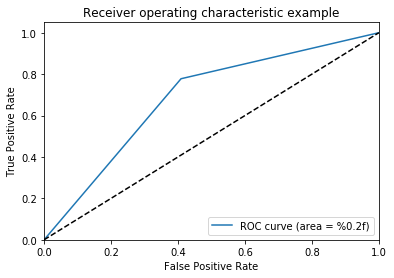

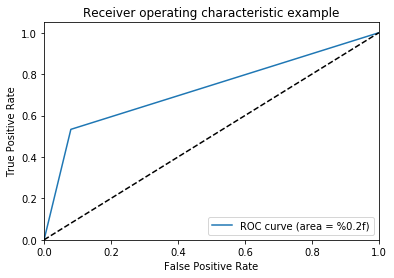

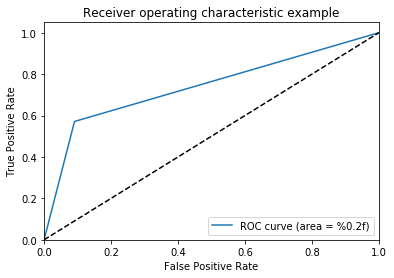

In [19]:
# Compute ROC curve and ROC area for each class
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(roc_auc)
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
for i in range(3):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)'.format(roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


In [51]:
#alaa
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("confusion matrix of : ",cm)

def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='confusion matrix',
                         cmap=plt.cm.Reds):
    # this funcation print & plots confusion matrix
    # normalize can be applied by  normalize=True,
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks= np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm= cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
        print("normalized confusion matrix")
    else:
        print(" confusion matrix, without normalized")
    print(cm)

    thresh=cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    
    '''input to confusion_matrix must be a list of predictions, not OHEs (one hot encodings). Call argmax on your y_test and y_pred, and you should get what you expect.'''

confusion matrix of :  [[16  2  0]
 [ 9  6  0]
 [ 5  0  2]]


 confusion matrix, without normalized
[[16  2  0]
 [ 9  6  0]
 [ 5  0  2]]


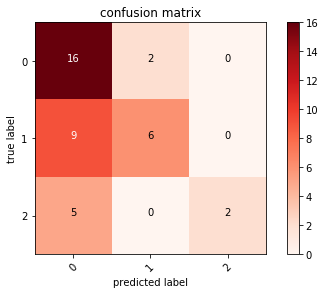

In [57]:
from sklearn.utils.multiclass import unique_labels
classes = unique_labels(y_test, y_pred)
plot_confusion_matrix(cm,classes)

In [58]:
auc_value=sklearn.metrics.roc_auc_score(y_test, y_pred)

In [59]:
auc_value

0.717089947089947